# Supercritical Pitchfork Bifurcation of Euler's Column

***

This notebook shows the reproduction of the supercritical pitchfork bifurcation of Euler's column with MSC Nastran SOL 106. Following the different buckling calculation methods demonstrated in our [last notebook](01_Buckling_Analysis_of_Euler_Column.ipynb), now we want to test the nonlinear capabilities of SOL 106 by reproducing the bifurcation behavior of Euler's column. We first recall the analytical results for a 1 DOF system and then we move on to the numerical computations. Different methods and load case sequences are investigated to explore the branches of Euler's column supercritical pitchfork bifurcation.

* [1 DOF system](#1dof)
* [Setup of the numerical model](#numerical-model)
* [Load case sequence definition](#subcases-definition)
* [Full Newton method](#newton)
* [Arc-length method](#arc-length)
    * [Investigation of equilibrium paths around $P_x/P_\text{SOL 105}=2$](#pxpcr2-investigation)
    * [Reduced compression force](#reduced-compression)
* [Final supercritical pitchfork bifurcation analysis](#final)
* [Conclusions](#conclusions)

## 1 DOF system <a name="1dof"></a>

***

Let's take the 1 DOF system represented below, composed by two inextensible and initially collinear rods connected by a linear torsional spring and subjected to the axial compressive load $P$.

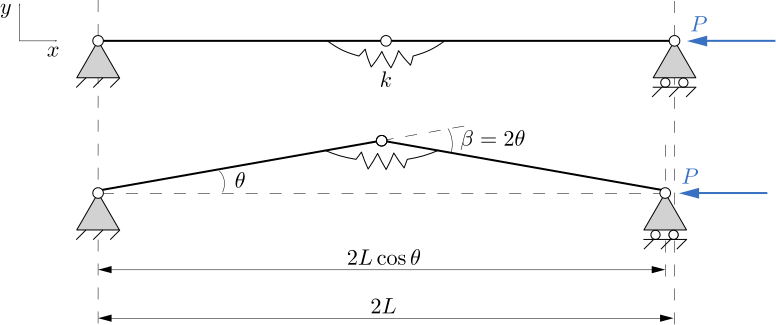

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '02_CollinearRods.svg'))

The equilibrium equation is satisfied under two conditions:

$$\theta=0$$

$$\frac{P}{P_{cr}}=\frac{\theta}{\sin\theta}$$
where $\theta=0$ is the trivial solution and $P_{cr}=2k/L$ is the critical buckling load.

For $\theta=0$ the equilibrium is stable when $P<P_{cr}$ and unstable when $P>P_{cr}$, while for $P/P_{cr}=\theta/\sin\theta$ the equilibrium is always stable.

If we add an imperfection to the system, such as the initial angle $\theta_0$ shown below, the equilibrium changes.

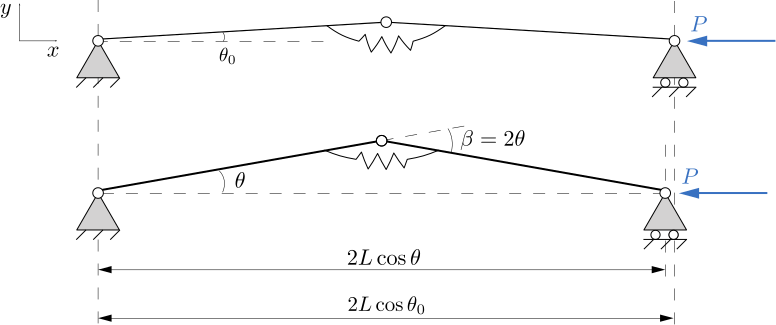

In [2]:
SVG(filename=os.path.join('resources', '02_ImperfectionRods.svg'))

The symmetry of the problem is broken the equilibrium is found for the following condition:
$$\frac{P}{P_{cr}}=\frac{\theta-\theta_0}{\sin\theta}.$$

The equilibrium is stable for $\left(\theta-\theta_0\right)/\tan\theta<1$ and unstable for $\left(\theta-\theta_0\right)/\tan\theta>1$.

Let's plot the above expressions and observe the difference with respect to the system without imperfection.

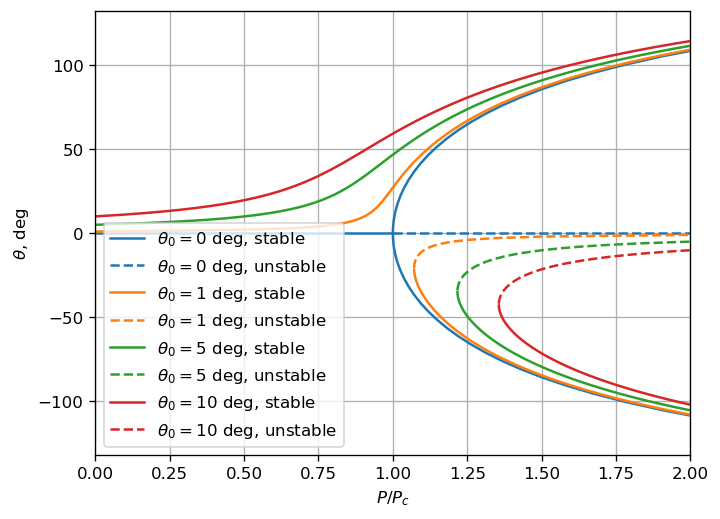

In [3]:
import matplotlib.pyplot as plt  # plotting package
import numpy as np  # package for matrix operations

plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

# Create new figure with one subplot
fig = plt.figure()
ax = fig.add_subplot()

# Plot trivial stable solution of perfect system
theta_trivial_stable = np.array([0., 0.])  # deg
load_trivial_stable = np.array([0., 1.])
stable_line = ax.plot(load_trivial_stable, theta_trivial_stable, color=colors[0], label='$\\theta_0=0$ deg, stable')

# Plot nontrivial stable solution of perfect system
theta_max = 120  # deg
theta_nontrivial = np.linspace(-theta_max, theta_max)  # deg
load_nontrivial = np.deg2rad(theta_nontrivial)/np.sin(np.deg2rad(theta_nontrivial))
ax.plot(load_nontrivial, theta_nontrivial, color=colors[0])

# Plot trivial unstable solution of perfect system
theta_trivial_unstable = np.array([0., 0.])  # deg
load_trivial_unstable = np.array([1., np.max(load_nontrivial)])
ax.plot(load_trivial_unstable, theta_trivial_unstable, '--', color=colors[0], label='$\\theta_0=0$ deg, unstable')

# Plot stable and unstable solution of system with imperfections
imperfections = [1, 5, 10]  # [deg]
for count, theta_0 in enumerate(imperfections):  # iterate through initial angles theta_0
    theta_negative = np.arange(-theta_max, 0)
    theta_positive = np.arange(theta_0, theta_max + 1)
    load_theta_negative = np.deg2rad(theta_negative - theta_0)/np.sin(np.deg2rad(theta_negative))
    load_theta_positive = np.deg2rad(theta_positive - theta_0)/np.sin(np.deg2rad(theta_positive))
    stability_theta_negative = np.deg2rad(theta_negative - theta_0)/np.tan(np.deg2rad(theta_negative))
    ax.plot(load_theta_negative[stability_theta_negative<1], theta_negative[stability_theta_negative<1], color=colors[count + 1],
            label=f'$\\theta_0={theta_0:d}$ deg, stable')
    ax.plot(load_theta_negative[stability_theta_negative>1], theta_negative[stability_theta_negative>1], '--', color=colors[count + 1],
            label=f'$\\theta_0={theta_0:d}$ deg, unstable')
    ax.plot(load_theta_positive, theta_positive, color=colors[count + 1])

# Set plot appearance
ax.set_ylabel('$\\theta$, deg')
ax.set_xlabel('$P/P_c$')
ax.set_xlim([0, 2])
ax.legend()
ax.grid()
plt.show()

We observe the presence of a supercritical pitchfork bifurcation for the perfect system, while the imperfect system presents a so-called broken bifurcation. This broken bifurcation moves away from the pitchfork bifurcation of the perfect system as the imperfection becomes larger.

## Setup of the numerical model <a name="numerical-model"></a>

***

Let's setup our numerical model for the analysis with Nastran. We consider the same column of our [last notebook](01_Buckling_Analysis_of_Euler_Column.ipynb#euler) and we create a `BDF` object calling the function `create_base_bdf` from the `column_utils` module.

In [4]:
from resources import column_utils

E = 207000.  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
rho = 7.8e-4  # density [tons/mm^3]
d = 20  # diameter [mm]
l = 420  # length [mm]
no_elements = 420  # number of beam elements
bdf_input = column_utils.create_base_bdf(young_modulus=E, poisson_ratio=nu, density=rho, diameter=d, length=l, no_elements=no_elements)

subcase=0 already exists...skipping


Our `BDF` object includes nodes, beam elements, material properties, boundary conditions, unit compression force and some parameters to define the output files. We can check its content with the `get_bdf_stats` method.

In [5]:
print(bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.loads[4]: 1
  FORCE:   1

bdf.spcadds[3]: 1
  SPCADD:  1

bdf.spcs[1]: 1
  SPC1:    1

bdf.spcs[2]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 421

bdf.elements: 0
  CBEAM    : 420

bdf.properties: 0
  PBEAML   : 1

bdf.materials: 0
  MAT1     : 1




Before moving on to the definition of the load case sequence, we recall the buckling load calculated by SOL 105 in our [last notebook](01_Buckling_Analysis_of_Euler_Column.ipynb#linear-buckling), which we will use to nondimensionalize the results.

In [6]:
sol_105_buckling_load = 90578.  # [N]

## Load case sequence definition <a name="subcases-definition"></a>

***

To reproduce the supercritical pitchfork bifurcation of Euler's column we need to explore the associated paths of the equilibrium diagram. This means that we need to look for the stable path up to the buckling load, the unstable branch beyond the buckling load and one of the two symmetrical stable branches. In addition, we also want to visualize the broken pitchfork, in order to observe the influence of an initial imperfection or of an eccentricity in the load.

We are going to approach this problem by defining a load case sequence that will allow us to move along the different paths of the equilibrium diagram of Euler's column. In SOL 106 Nastran's subcases are executed in a sequential way, that is to say with each subcase starting where the previous one ends. We define the following sequence of subcases to explore all the paths described earlier.

1. Apply a compression load larger than the buckling load at the roller-supported end of the column. In this subcase we expect to end on the unstable branch of the bifurcation.

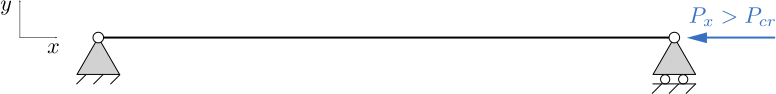

In [7]:
SVG(filename=os.path.join('resources', '02_Subcase1.svg'))

2. Add a small transverse load at the middle of the column. This will break the symmetry of the problem and consequently also the supercritical pitchfork bifurcation. We expect the equilibrium point to move onto the broken pitchfork, resulting in a deflection of the column in the same direction of the applied transverse load.

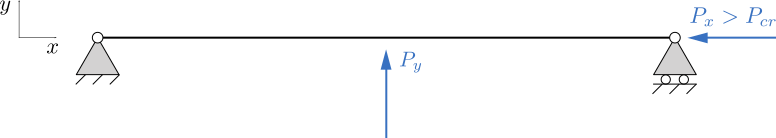

In [8]:
SVG(filename=os.path.join('resources', '02_Subcase2.svg'))

3. Remove the transverse load in order to restore the symmetry of the problem. As a consequence, we expect also the supercritical pitchfork bifurcation to be restored. Thus, the equilibrium point should move onto the stable branch of the pitchfork corresponding to the direction of the tranverse load that was just removed. We expect to observe a non-zero deflection of the column.

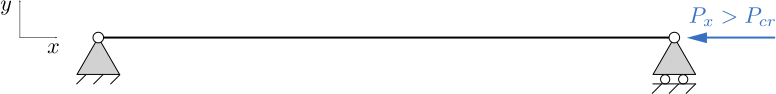

In [9]:
SVG(filename=os.path.join('resources', '02_Subcase1.svg'))

4. Remove the compression load. We expect this to move the equilibrium point along the stable branch of the pitchfork until the applied load is equal to the buckling load and then back to the undeformed state of the column.

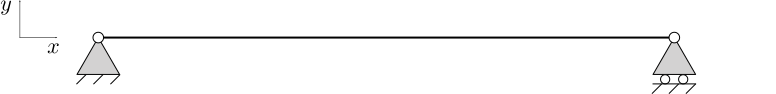

In [10]:
SVG(filename=os.path.join('resources', '02_Subcase4.svg'))

5. Apply both the compression and the transverse load at the same time. This will let us visualize the equilibrium path of the broken pitchfork.

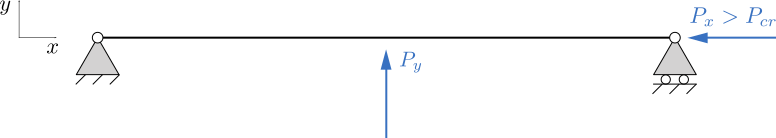

In [11]:
SVG(filename=os.path.join('resources', '02_Subcase2.svg'))

Let's start by defining the compression force and the transverse force, which we will later assign to the different load sets. We consider a compression force equal to twice the buckling load calculated by SOL 105, $P_x/P_\text{SOL 105}=2$. The FORCE card corresponding to the compression force has already been created by the `create_base_bdf` function, so we only need to change its magnitude.

In [12]:
compression_force_set_id = list(bdf_input.loads.keys())[0]  # retrieve identification number of FORCE card representing the compression load
bdf_input.loads[compression_force_set_id][0].mag = sol_105_buckling_load*2  # change magnitude of the force to twice the buckling load calculated by SOL 105

Then we define the transverse force as a fraction of the buckling load, $P_y/P_\text{SOL 105}=1/100$. This time we need to create a new FORCE card.

In [13]:
transverse_force_set_id = compression_force_set_id+1
middle_node_id = int(no_elements/2+1)  # identification number of the node of application of the transverse force
transverse_force_magnitude = sol_105_buckling_load/100
transverse_force_direction = [0., 1., 0.]
bdf_input.add_force(sid=transverse_force_set_id, node=middle_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)

FORCE          5     211          905.78      0.      1.      0.

Now we define the two load combinations that we need for our subcases: one with compression and transverse force and one with no applied force.

In [14]:
# Define load set with combined compression and transverse forces
combined_load_set_id = transverse_force_set_id+1
bdf_input.add_load(combined_load_set_id, scale=1., scale_factors=[1., 1.], load_ids=[compression_force_set_id, transverse_force_set_id])

# Define load set with no applied force
zero_load_set_id = combined_load_set_id+1
bdf_input.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])

LOAD           7      1.      0.       4

We finally define our subcases as explained earlier using the `create_static_load_subcase` function from the `pynastran_utils` module.

In [15]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=1, load_set_id=compression_force_set_id)  # first subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=2, load_set_id=combined_load_set_id)  # second subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=3, load_set_id=compression_force_set_id)  # third subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=4, load_set_id=zero_load_set_id)  # fourth subcase
pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=5, load_set_id=combined_load_set_id)  # fifth subcase

## Full Newton method <a name="newton"></a>

***

The first nonlinear iteration strategy that we want to test is the full Newton method. Consequently, we choose SOL 106 as solution sequence, add the parameter `PARAM,LGDISP,1` to consider large displacement effects, and define a NLPARM card with the following parameters:
* `ninc=100` to set 100 load increments of constant size;
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration;
* `max_iter=25` to set the maximum number of iterations for each load increment;
* `conv='PUV'` to select convergence criteria based on load equilibrium and displacement errors with vector component method (convergence checking is performed on the maximum vector component of all components in the model);
* `int_out='YES'` to process the output for every computed load increment;
* `eps_p=1e-3` and `eps_u=1e-3` to set the error tolerance for the load and displacement criteria, respectively;
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment.

Finally, we select the NLPARM card in the case control deck as default for all subcases.

In [16]:
bdf_input.sol = 106  # assign solution sequence
bdf_input.add_param('LGDISP', [1])  # enable large displacement effects
nlparm_id = 1  # nlparm card id
bdf_input.add_nlparm(nlparm_id=nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)  # add nlparm card
bdf_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)  # nlparm card default for all subcases

Similarly to our [previous notebook](01_Buckling_Analysis_of_Euler_Column.ipynb#nonlinear-buckling), all the nonlinear analysis parameters used here are inspired by the [Shallow Cylindrical Shell Snap-through example](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/mdug_SOL400/mdug_SOL400_38/mdug.SOL400.38.xhtml#TOC_Shallow_Cylindrical) from the MSC Nastran *Demontration Problems Guide - Implicit Nonlinear*.

We can now run the analysis with Nastran! Let's define the name of the analysis directory and of the input file and let's call the function `run_analysis` from the `pynastran_utils` module.

In [17]:
analysis_directory_name = '02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
input_name = 'full_newton_method'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=input_name, run_flag=False)

Nastran job full_newton_method.bdf completed
Wall time: 74.0 s


Once the analysis is done, we can read the op2 file and find the load and displacement history for all subcases using the function `read_load_displacement_history_from_op2` from the `pynastran_utils` module. This function returns the history of load steps, overall applied loads, and displacements and rotations at the indicated node for each subcase of the analysis. We read the displacements and rotations at the hinge-supported node (node id 1) because we want to assess the equilibrium diagram of the column in terms of the rotation $\theta$ at that node, similarly to what we have done for the [1-DOF system](#1dof) discussed earlier.

In [18]:
from pyNastran.op2.op2 import read_op2  # function to read op2 file

op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)  # read op2 file without display of debug messages
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)  # read load and displacement history

We want to plot the results of our analysis in terms of equilibrium paths. For each converged iteration of each subcase we want to visualize:
 * load step versus $\theta$;
 * applied load $P_x$ versus $\theta$;
 * applied load $P_y$ versus $\theta$.

The load step represents the progress of the nonlinear analysis towards the final applied load. It ranges from 0 to 1 for the first subcase, from 1 to 2 for the second subcase and so on.

In addition, we also want to print the value of $\theta$ at the end of each subcase. We define the `plot_2d_equilibrium_paths` function to do the plotting and print the value of $\theta$ and we call it to show the results of our analysis.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = 124.04 degrees
Subcase 3: theta = 124.08 degrees
Subcase 4: theta = 0.00 degrees
Subcase 5: theta = 124.04 degrees


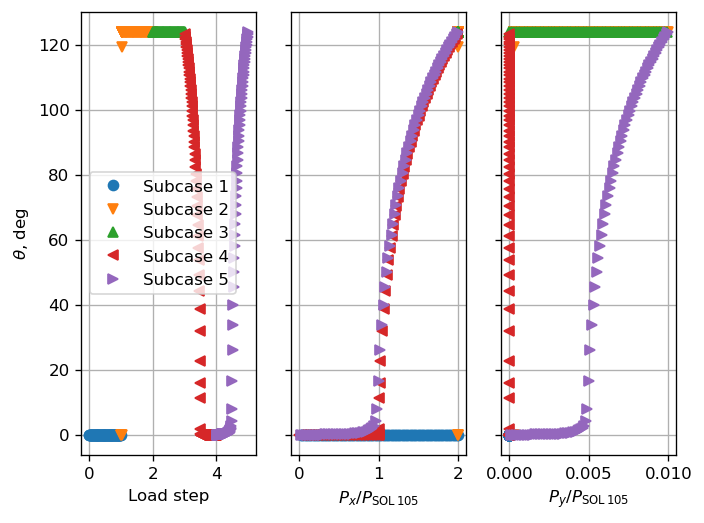

In [19]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

markers = list(Line2D.markers.keys())[2:]  # store list of marker characters to plot different marker for each subcase

def plot_2d_equilibrium_paths(disp, steps, loads):
    # Create figure with 3 subplots
    _, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
    # Iterate over the subcases
    for subcase_id in disp:
        # Convert rotation angle from radians to degrees
        theta = np.rad2deg(disp[subcase_id][:,5])
        # Print rotation at the end of subcase
        print(f'Subcase {subcase_id:d}: theta = {theta[-1]:.2f} degrees')
        # Plot load step vs rotation
        axs[0].plot(steps[subcase_id], theta, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along x vs rotation
        axs[1].plot(-loads[subcase_id][:,0]/sol_105_buckling_load, theta, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))  # sign of load along x is inverted to show a positive load in the plot
        # Plot applied load along y vs rotation
        axs[2].plot(loads[subcase_id][:,1]/sol_105_buckling_load, theta, markers[subcase_id - 1], label='Subcase {:d}'.format(subcase_id))
    # Set plot appearance
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('$\\theta$, deg')
    axs[0].grid(visible=True)
    axs[1].set_xlabel('$P_x/P_\mathrm{SOL\/105}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel('$P_y/P_\mathrm{SOL\/105}$')
    axs[2].grid(visible=True)
    axs[0].legend()
    plt.show()

plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)  # call function to show results of the analysis

As expected, the results show the presence of a bifurcation. We can make the following observations.
* During the first subcase the rotation $\theta$ is always null. The equilibrium point moves along a stable equilibrium path for $P_x/P_\text{SOL 105}<1$ and then along the unstable branch of the bifurcation for $P_x/P_\text{SOL 105}>1$.
* In subcase 2, $\theta$ jumps from zero to about 124 degrees, with the equilibrium point moving from the unstable branch of the pitchfork to the broken pitchfork.
* In the third subcase the equilibrium point moves from the broken pitchfork to the stable branch of the pitchfork. Unexpectedly, at the end of the subcase $\theta$ is slightly smaller with respect to the value at the end of subcase 2. This is in contrast with the results of the 1 DOF system, where the imperfect sytem always shows a larger value of $\theta$ for the same applied load $P/P_{cr}$ with respect to the perfect system.
* In subcase 4, the equilibrium point moves along the stable branch of the unbroken pitchfork as the column is unloaded and for $P_x/P_\text{SOL 105}<1$ it traverses a stable equilibrium path until the structures goes back to its undeformed state (null rotation).
* In subcase 5 we can observe the equilibrium path corresponding to the broken pitchfork. In particular, it is evident how the path of the broken pitchfork deviates from the one of the unbroken pitchfork, especially close to $P_x/P_\text{SOL 105}=1$. As expected, the final value of $\theta$ corresponds to the one obtained at the end of the second subcase.

Except for the value of $\theta$ at the end of the third subcase, all the observations are in line with our expectations.

We can also visualize the equilibrium paths with a 3D plot, showing $\theta$, $P_x/P_\text{SOL 105}$ and $P_y/P_\text{SOL 105}$ at the same time. We define the function `plot_3d_equilibrium_paths` for such purpose and we call it to plot our results in 3D.

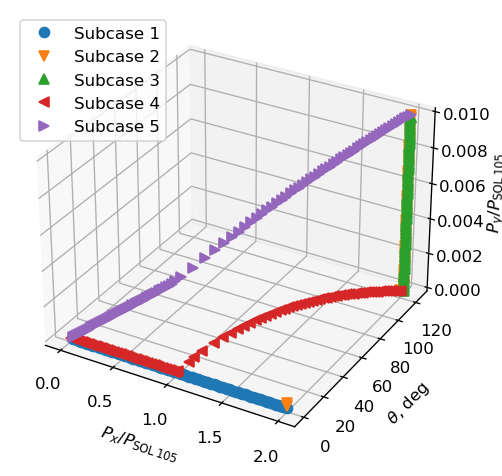

In [20]:
def plot_3d_equilibrium_paths(disp, loads):
    # Create figure with three-dimensional axes
    plt.figure()
    ax_3d = plt.axes(projection='3d')
    # Plot load applied along x vs rotation of pin-supported node vs applied along y
    for subcase_id in disp:
        ax_3d.plot3D(-loads[subcase_id][:,0]/sol_105_buckling_load, np.rad2deg(disp[subcase_id][:,5]), loads[subcase_id][:,1]/sol_105_buckling_load, markers[subcase_id - 1],
                     label='Subcase {:d}'.format(subcase_id))  # sign of load along x is inverted to show a positive load in the plot
    # Set plot appearance
    ax_3d.set_xlabel('$P_x/P_\mathrm{SOL\/105}$')
    ax_3d.set_ylabel('$\\theta$, deg')
    ax_3d.set_zlabel('$P_y/P_\mathrm{SOL\/105}$')
    ax_3d.legend()
    ax_3d.grid(visible=True)
    plt.show()

plot_3d_equilibrium_paths(displacements, applied_loads)  # call function to show results of the analysis

Here we can recognize the equilibrium path of the supercritical pitchfork bifurcation on the $P_x/P_{cr}-\theta$ plane and the jump of $\theta$ during subcase 2. We remind that the employed Newton method is based on load control, so the jump in subcase 2 suggests the presence of a limit point, which we should be able to observe using the arc-length method. Finally, the 3D view enables the observation of two features:
* the path of the broken pitchfork is actually three-dimensional when we also consider the transverse load as an independent parameter of the system;
* the pitchfork and the broken pitchfork are connected by the equilibrium path found in subcase 3.

## Arc-length method <a name="arc-length"></a>
Now we want to analyze the supercritical pitchfork bifurcation using the arc-length incremental solution strategy. In this way we will be able to follow the equilibrium paths of the column also beyond limit points.

To use the arc-length method in SOL 106, we need to add a NLPCI card with the following parameters:
* `Type='CRIS'` to set Crisfield constraint type;
* `minalr=.01` and `maxalr=1.0001` to set the minimum and maximum allowable arc-length adjustment ratio between increments, $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$. Smaller values of $MAXALR$ were tested, but the analysis appeared to get stuck during subcase 4 around the bifurcation point;
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$ (where $I_{max}$ represents the number of iterations required for convergence in the previous load increment);
* `mxinc=1000` to set the maximum number of controlled increment steps allowed within a subcase.

In [21]:
bdf_input.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.0001, desiter=5, mxinc=1000)

NLPCI          1    CRIS     .01  1.0001      0.               5    1000

Let's define the name of our input file and let's run the analysis.

In [22]:
input_name = 'arclength_method'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=input_name, run_flag=False)

Nastran job arclength_method.bdf completed
Wall time: 143.0 s


We plot the results of our analysis in an analogous way as done for the full Newton method.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -0.38 degrees
Subcase 3: theta = 0.00 degrees
Subcase 4: theta = 4.10 degrees


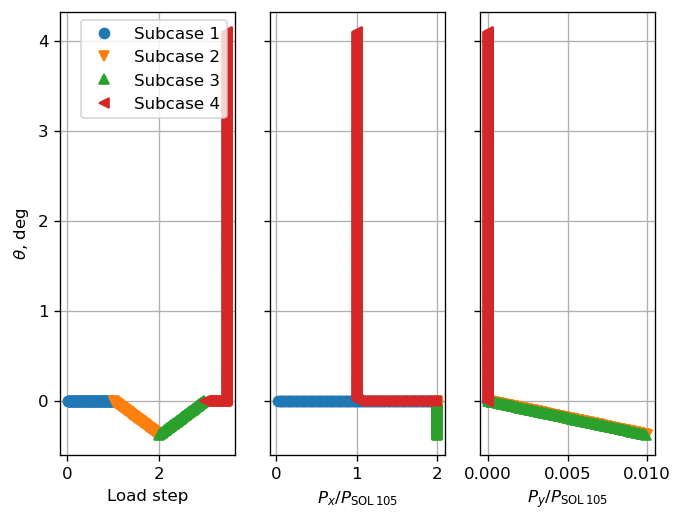

In [23]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)

# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)

We can easily observe some differences with respect to the full Newton method analysis.
* After the first subcase, the arc-length solver does not succed to move from the unstable branch of the pirchfork to the broken pitchfork. The solver appears to follow a path with negative $\theta$ for a positive transverse load, which means that the column is deflecting in the opposite direction with respect to the applied transverse load. This is counterintuitive and needs further investigation.
* When unloading the structure in subcase 4, the arc-length solver branch-switches to one of the stable branch of the pitchfork bifurcation instead of following the "straight" path. This suggests that the Newton method would be more appropriate to force the solver to unload the structure to the ground state.

Also in this case we plot the 3D equilibrium paths to have another visualization of our results.

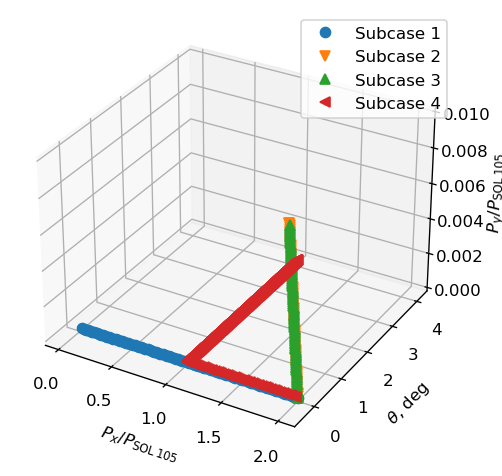

In [24]:
plot_3d_equilibrium_paths(displacements, applied_loads)

Considering the jump that we observed with the Newton method in subcase 2, we would expect to observe a limit point with the arc-length method. However, we cannot see any evidence of such limit point, rather the structure follows an equilibrium path with slightly negative values of $\theta$. As a consequence, we need to investigate the equilibrium path around $P_x/P_\text{SOL 105}=2$ more in detail.

### Investigation of equilibrium paths around $P_x/P_\text{SOL 105}=2$ <a name="pxpcr2-investigation"></a>

We investigate the behavior of the equilibrium paths around $P_x/P_\text{SOL 105}=2$ applying a large transverse force first in one direction and then in the opposite one. For this purpose we need to make a deep copy of our `BDF` object and modify the subcases in the following way:
1. Subcase 1 stays unchanged.
2. In subcase 2 we keep the compression force and apply a large transverse force, setting $P_y/P_\text{SOL 105}=100$, with the aim of visualizing more extensively the shape of the equilibrium path.
3. In subcase 3 we keep the compression force and reverse the transverse force, setting $P_y/P_\text{SOL 105}=-100$. This means that we apply an equal and opposite transverse force with respect to the one applied in subcase 2. In this way we study the other side of the equilibrium path.

Subcases 4 and 5 are removed.

We use the same NLPARM and NLPCI cards used previously, we only increase the maximum number of controlled increment steps allowed within a subcase to 2000 to give plenty of room to the analysis to converge to our prescribed loads.

In [25]:
# Increase maximum number of increments allowed within a subcase and create deep copy
bdf_input.nlpcis[nlparm_id].mxinc = 2000
pxpcr2_investigation_input = bdf_input.__deepcopy__({})

# Modify subcase 2
pxpcr2_investigation_input.loads[transverse_force_set_id][0].mag = sol_105_buckling_load*100  # change magnitude of transverse force

# Modify subcase 3
combined_load_opposite_direction_set_id = zero_load_set_id+1  # define identification number of load combination with reversed transverse force
scale_factors = [1., -1.]  # define scale factors of the forces, -1 means transverse force applied in opposite direction w.r.t. subcase 2
pxpcr2_investigation_input.add_load(combined_load_opposite_direction_set_id, 1., scale_factors, [compression_force_set_id, transverse_force_set_id])  # add new load combination with reversed transverse force
pxpcr2_investigation_input.subcases[3].params['LOAD'][0] = combined_load_opposite_direction_set_id  # select load combination in subcase control deck

# Remove subcases 4 and 5
del pxpcr2_investigation_input.subcases[4]
del pxpcr2_investigation_input.subcases[5]

Let's run the analysis and visualize the results.

Nastran job arclength_method_PxPcr2_investigation.bdf completed
Wall time: 256.0 s


Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -256.42 degrees
Subcase 3: theta = 256.43 degrees


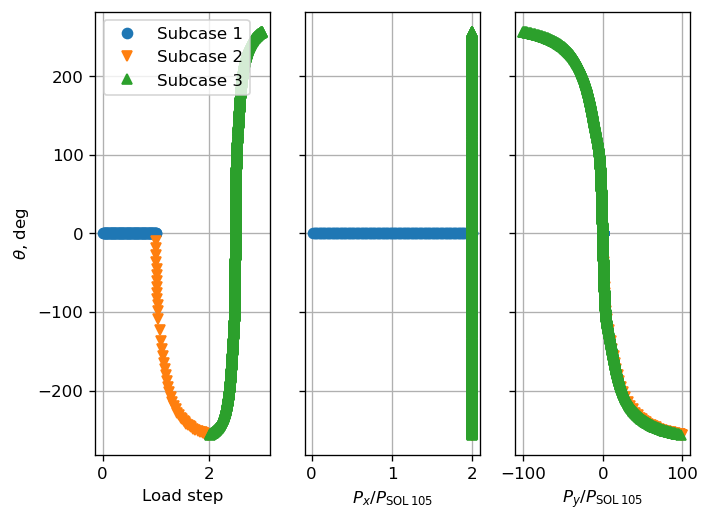

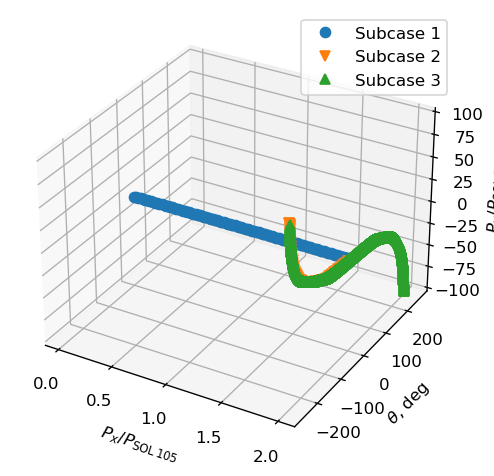

In [26]:
input_name = 'arclength_method_PxPcr2_investigation'  # input name
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=pxpcr2_investigation_input, filename=input_name, run_flag=False)  # run analysis

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

From the results it appears that the equilibrium path on the $P_x/P_\text{SOL 105}=2$ plane predicts a downward deflection of the column for an upward transverse force and vice versa. Once again, we cannot observe the presence of a limit point and the equilibrium path does not seem to justify the jump that we observed with the Newton method.

Let's try a different sequence of subcases to investigate the equilibrium paths on the $P_x/P_\text{SOL 105}=2$ plane. We create a deep copy of our orifinal `BDF` object and we define the following subcases.
1. Apply combined compression and transverse force, with $P_x/P_\text{SOL 105}=2$ and $P_y/P_\text{SOL 105}=1/100$. In this way we expect the equilibrium point to move along the path of the broken pitchfork.
2. Keep the compression load and reverse the transverse load, setting $P_y/P_\text{SOL 105}=-100$. The idea here is to observe whether we are able to switch from one side of the broken pitchfork to the other side. We set a larger magnitude for the transverse load to overcome potential limit points in the equilibrium path.

Remove subcases 3, 4 and 5. This time we increase $MAXALR$ to $1.1$, thus allowing larger arc-length adjustments between increments, because we observed that the analysis could not converge to the prescribed loads when using very small maximum arc-length adjustment ratios.

In [27]:
# Increase maximum arc-length adjustment ratio and create deep copy
bdf_input.nlpcis[nlparm_id].maxalr = 1.1
alternative_subcases_input = bdf_input.__deepcopy__({})

# Modify subcase 1
alternative_subcases_input.subcases[1].params['LOAD'][0] = combined_load_set_id


# Modify subcase 2
scale_factors = [1., -10000.]  # define scale factors to apply a reversed transverse force of Py/Pcr = -100
alternative_subcases_input.add_load(combined_load_opposite_direction_set_id, 1., scale_factors, [compression_force_set_id, transverse_force_set_id])  # add new load combination with reversed transverse force
alternative_subcases_input.subcases[2].params['LOAD'][0] = combined_load_opposite_direction_set_id  # select load combination in subcase control deck

# Remove subcases 3 to 5
del alternative_subcases_input.subcases[3]
del alternative_subcases_input.subcases[4]
del alternative_subcases_input.subcases[5]

Once again, let's run the analysis and visualize the results.

Nastran job arclength_method_PxPcr2_investigation_alternative_subcases.bdf completed
Wall time: 2514.0 s


Subcase 1: theta = 124.04 degrees
Subcase 2: theta = 90.02 degrees


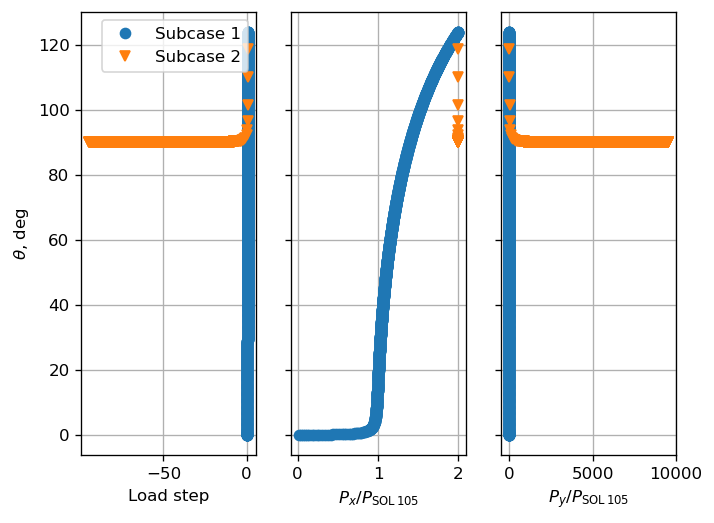

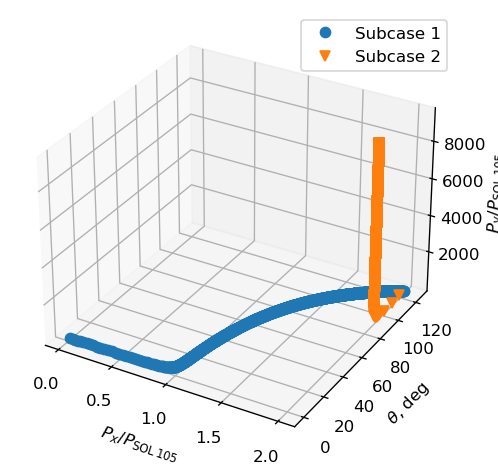

In [28]:
input_name = 'arclength_method_PxPcr2_investigation_alternative_subcases'  # input name
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, filename=input_name, run_flag=True)  # run analysis

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)

# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

The analysis stops because it exceeds the allowed maximum number of controlled iterations and it does not converge to the desired load in subcase 2. We can observe negative load steps, indicating that the arc-length tries to seek an equilibrium point in the same loading direction of the previous subcase. As a consequence, the arc-length solver applies an increasing upward force instead of applying the prescribed downward force.

Since the arc-length method seems to encounter issues when the sign of the transverse force is inverted, we try to repeat the analysis substituting the arc-length method with the full Newton method in subcase 2. For this purpose we need to add another `NLPARM` card and assign its id to subcase 2.

In [29]:
nlparm2_id = 2
alternative_subcases_input.add_nlparm(nlparm2_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
alternative_subcases_input.case_control_deck.subcases[2].add_integer_type('NLPARM', nlparm2_id)  # select NLPARM card in subcase 2 control deck

Then we run the analysis and plot the results.

Nastran job mixed_methods_PxPcr2_investigation_alternative_subcases.bdf completed
Wall time: 198.0 s


Subcase 1: theta = 124.04 degrees
Subcase 2: theta = 267.67 degrees


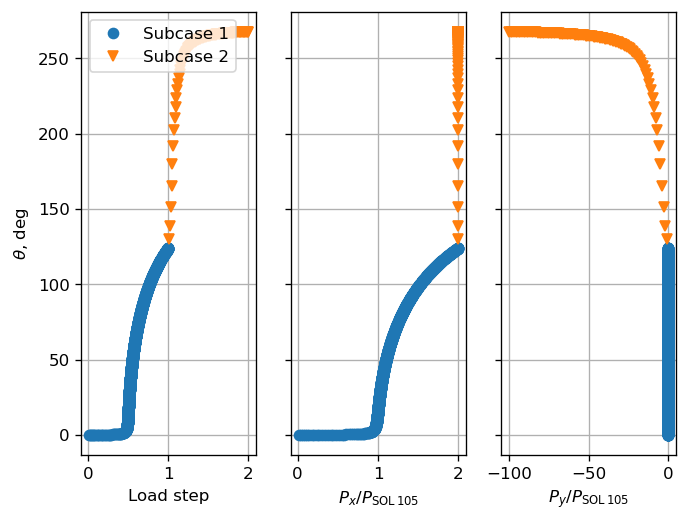

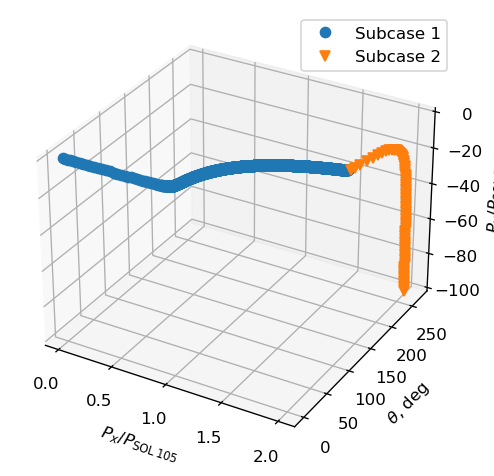

In [30]:
input_name = 'mixed_methods_PxPcr2_investigation_alternative_subcases'  # input name
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, filename=input_name, run_flag=True)  # run analysis

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)

# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

Once again, the analysis stops becasue it exceeds the allowed maximum number of controlled iterations. However, this time we observe that the Newton method is able to traverse the equilibrium path along the prescribed loading direction. The results indicate that for the investigated range of transverse loads the equilibrium path does not seem to point towards the other side of the broken pitchfork.

### Reduced compression force <a name="reduced-compression"></a>

At this point we want to assess how the equilibrium paths change across different $P_x/P_\text{SOL 105}=c$ planes, with $c$ constant. We use the same load case sequence defined for the `alternative_subcase_input` object, with the following values of $P_x/P_\text{SOL 105}$: $1.1$, $1.4$, $1.7$. For each value of $P_x/P_\text{SOL 105}$ we adjust the value of $P_y/P_\text{SOL 105}$ in the second subcase. The reason for this will be evident when we'll look at the results.

We proceed with modifying the subcases, running the analysis and plotting the results for each value of $P_x/P_\text{SOL 105}$.

Px/Pcr=1.1
Nastran job arclength_method_PxPcr_1_1.bdf completed
Wall time: 69.0 s


Subcase 1: theta = 50.66 degrees
Subcase 2: theta = -58.81 degrees


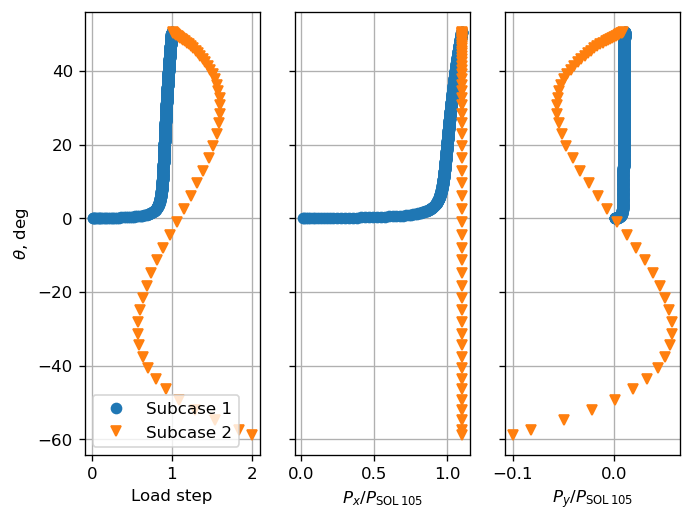

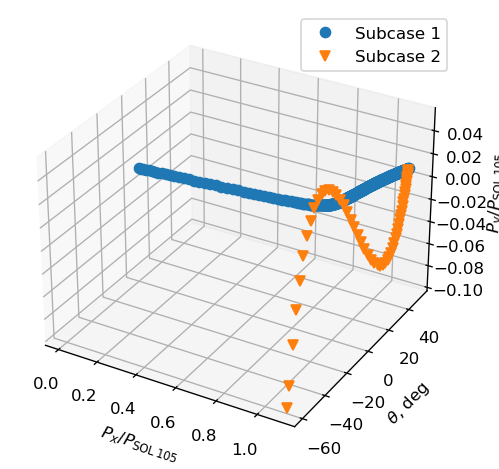

Px/Pcr=1.4
Nastran job arclength_method_PxPcr_1_4.bdf completed
Wall time: 133.0 s


Subcase 1: theta = 90.37 degrees
Subcase 2: theta = -97.01 degrees


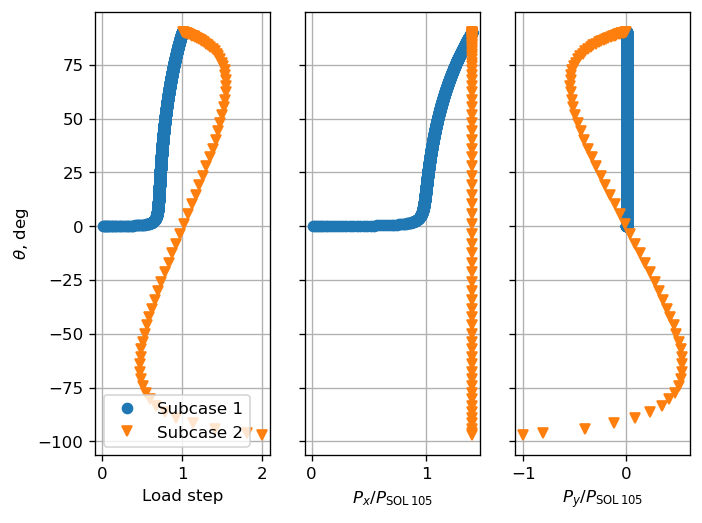

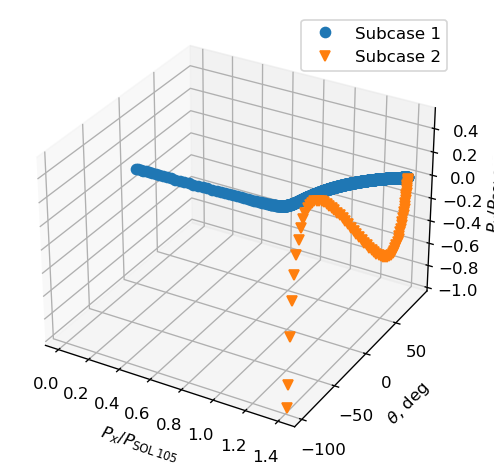

Px/Pcr=1.7
Nastran job arclength_method_PxPcr_1_7.bdf completed
Wall time: 179.0 s


Subcase 1: theta = 110.76 degrees
Subcase 2: theta = -105.68 degrees


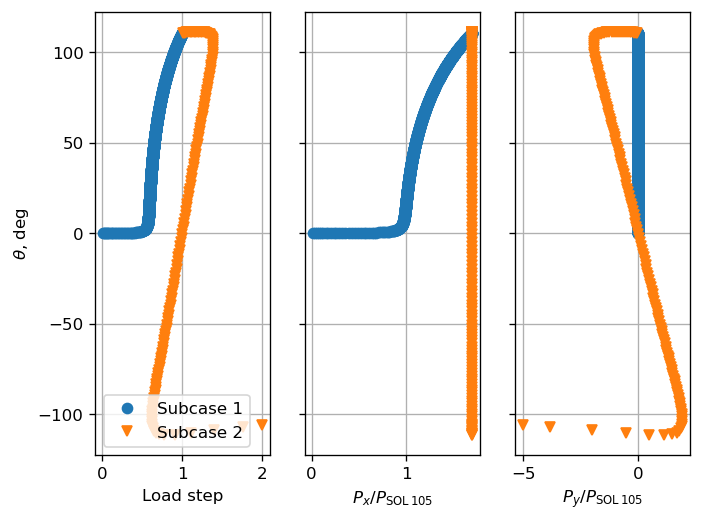

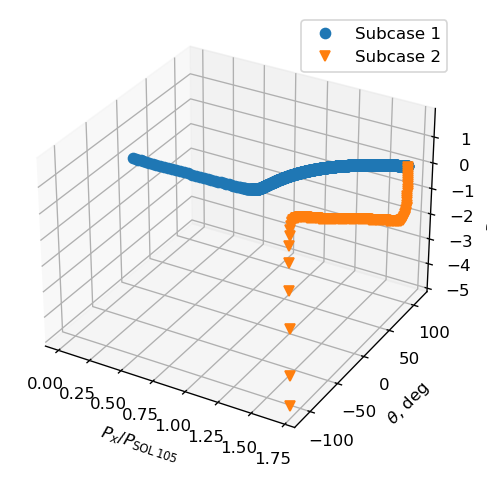

In [31]:
alternative_subcases_input.subcases[2].params['NLPARM'][0] = nlparm_id  # select the NLPARM card associated to the arc-length method for subcase 2

compression_force_factors = [1.1, 1.4, 1.7]  # define values of Px/Pcr
transverse_load_factors = [-1e1, -1e2, -5e2]  # define scale factors of Py/Pcr

# Iterate through the different values of Px/Pcr and Py/Pcr
for force_factor, scale_factor in zip(compression_force_factors, transverse_load_factors):
    # Print value of compression force
    print('\033[1m' + f'Px/Pcr={force_factor:.1f}' + '\033[0m')
    # Modify magnitude of compression force
    alternative_subcases_input.loads[compression_force_set_id][0].mag = sol_105_buckling_load*force_factor
    # Modify scale factor of transverse load in subcase 2
    alternative_subcases_input.load_combinations[combined_load_opposite_direction_set_id][0].scale_factors[1] = scale_factor
    # Define input name
    input_name = f'arclength_method_PxPcr_{force_factor:.1f}'.replace('.','_')
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, filename=input_name, run_flag=True)
    # Read op2 file
    op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, debug=None)
    # Read load displacement history
    load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
    # Plot equilibrium paths
    plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
    plot_3d_equilibrium_paths(displacements, applied_loads)

The results of these analyses show the presence of a snap-through behavior when moving from one side to the other of the broken pitchfork. Subcase 1 brings the equilibrium point on the broken pitchfork corresponding to an upward deflection of the column (positive $\theta$). In subcase 2 the positive transverse force is gradually unloaded and the negative transverse force is loaded on the structure. As a consequence, during this process the transverse force becomes null and then negative with increasing magnitude, until a limit point is encountered. After this point the transverse force decreases in magnitude until it becomes null and changes sign. Once again, the force increases in magnitude until it encounters another limit point, this time for a positive force. Subsequently, the force decreases in magnitude, becomes null, changes its sign back to negative and finally achieves the prescribed value.

It should be noted that $P_y$ becomes null three times along the equilibrium path. Once for a positive value of $\theta$, once for $\theta=0$ and once for a negative value of $\theta$. This means that when moving from one side of the broken pitchfork to the other, the equilibrium path crosses the branches of the supercritical pitchfork bifurcation, where $P_y$ is null.

Furthermore, we can observe that the curve describing the equilibrium path connecting the two sides of the pitchfork changes with the compression load $P_x$. Not only the location of the limit points is different, but the overall shape of the curve changes. For example, we can notice how the slope at the start of subcase 2 is different: if for $P_x/P_\text{SOL 105}=1.1$ and $1.4$ the rotation angle $\theta$ decreases, for $P_x/P_\text{SOL 105}=1.7$ the rotation angle $\theta$ has a slight increase before becoming smaller along the curve. This means that the level of compression of the column influences the equilibrium path connecting the two sides of the pitchfork. As a consequence, it is possible that for $P_x/P_\text{SOL 105}=2$ the equilibrium path becomes more complex and that we are not able to traverse it within the prescribed maximum number of iterations.

Finally, looking at the equilibrium point where $P_y=0$ and $\theta=0$, we notice the same seemingly nonphysical behavior that we observed in a previous analysis, that is to say downward deflection (negative $\theta$) for upward force (positive $P_y$) and vice versa. This can be explained by the fact that the points on that equilibrium path are all unstable, so when the column has a slight upward deflection, a downward force is needed to keep it in equilibrium and to prevent it from snapping to the stable branch of the pitchfork. Analogously, when the column has a slight downward deflection, an equilibrium configuration can only be obtained with the application of an upward force that prevents the column from snapping further downward.

## Final supercritical pitchfork bifurcation analysis <a name="final"></a>

***

We conclude this series of analyses with an investigation on both sides of the pitchfork. We define the following subcases.

1. Apply combined compression and transverse force, with $P_x/P_\text{SOL 105}=1.5$ and $P_y/P_\text{SOL 105}=1/100$, to move along the equilibrium path of the broken pitchfork.
2. Remove the transverse load to move the equilibrium point onto the stable branch of the pitchfork.
3. Apply a downward transverse load, setting $P_y/P_\text{SOL 105}=-1$, to move to the other side of the broken pitchfork. The final equilibrium point belongs to the side of the broken pitchfork corresponding to a downward deflection of the column.
4. Remove the transverse load to move the equilibrium point onto the other stable branch of the pitchfork. In this subcase we want to verify that the final rotation $\theta$ is equal and opposite to the one at the end of subcase 2.
5. Remove the compression load to walk the pitchfork back to the undeformed configuration of the structure. In this subcase we use the Newton method because the arc-length method seems to have issues with unloading the compression force.
6. Apply a compression force combined with a downward transverse force, setting $P_x/P_\text{SOL 105}=1.5$ and $P_y/P_\text{SOL 105}=-1$. In this way we check that the final value of $\theta$ is equal to the one obtained at the end of subcase 3. Also in this subcase we use the Newton method, this time because the arc-length method seems to have issues finding solutions in the opposite loading direction of the previous subcase.

In [32]:
# Modify magnitude of compression force
alternative_subcases_input.loads[compression_force_set_id][0].mag = sol_105_buckling_load*1.5

# Modify subcase 2
alternative_subcases_input.subcases[2].params['LOAD'][0] = compression_force_set_id

# Create subcase 3
alternative_subcases_input.load_combinations[combined_load_opposite_direction_set_id][0].scale_factors[1] = -1e2  # modify scale factor of reversed transverse force to apply Py/Pcr = -1
pynastran_utils.create_static_load_subcase(bdf_object=alternative_subcases_input, subcase_id=3, load_set_id=combined_load_opposite_direction_set_id)

# Create subcase 4
pynastran_utils.create_static_load_subcase(alternative_subcases_input, subcase_id=4, load_set_id=compression_force_set_id)

# Create subcase 5
pynastran_utils.create_static_load_subcase(alternative_subcases_input, subcase_id=5, load_set_id=zero_load_set_id)
alternative_subcases_input.case_control_deck.subcases[5].add_integer_type('NLPARM', nlparm2_id)  # set Newton method as nonlinear solution method

# Create subcase 6
pynastran_utils.create_static_load_subcase(alternative_subcases_input, subcase_id=6, load_set_id=combined_load_opposite_direction_set_id)
alternative_subcases_input.case_control_deck.subcases[6].add_integer_type('NLPARM', nlparm2_id)  # set Newton method as nonlinear solution method

We run the analysis, read the output file and plot the results.

Nastran job mixed_methods_PxPcr_1_5.bdf completed
Wall time: 184.0 s


Subcase 1: theta = 98.34 degrees
Subcase 2: theta = 98.28 degrees
Subcase 3: theta = -101.55 degrees
Subcase 4: theta = -98.28 degrees
Subcase 5: theta = -0.00 degrees
Subcase 6: theta = -101.55 degrees


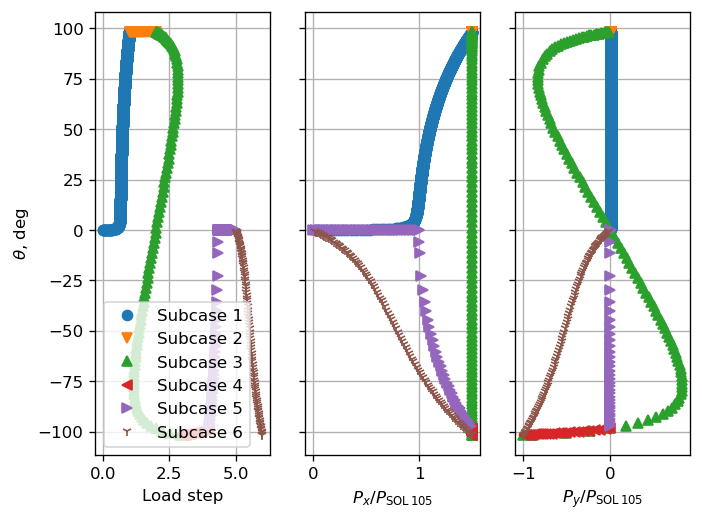

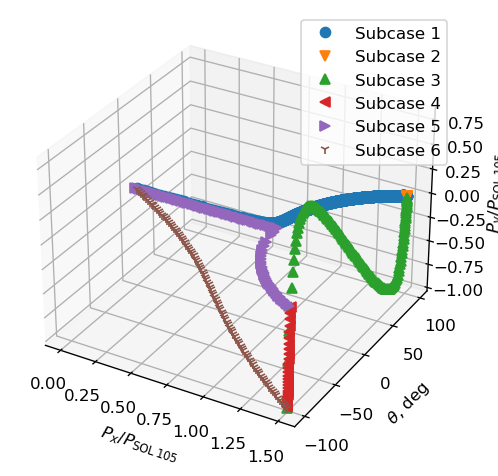

In [33]:
input_name = 'mixed_methods_PxPcr_1_5'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=alternative_subcases_input, filename=input_name, run_flag=True)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)

# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

# Plot equilibrium paths
plot_2d_equilibrium_paths(displacements, load_steps, applied_loads)
plot_3d_equilibrium_paths(displacements, applied_loads)

We can make the following observations.
* In subcase 1 the broken pitchfork is on the side corresponding to an upward deflection of the column, so in the same direction as the applied transverse load.
* Subcase 3 highlights the snap-through behavior of the column when the equilibrium point moves from one side to the other of the pitchfork.
* The rotation $\theta$ at the end of subcase 2 is equal and opposite to the one at the end of subcase 4.
* In subcase 5 the stable branch of the pitchfork is on the side corresponding to a downward deflection of the column, so in the same direction as the applied transverse load.
* In subcase 6 the broken pitchfork is again on the side corresponding to a downward deflection of the column, as the transverse force is applied in that direction. We can notice that the curve in the $P_x/P_\text{SOL 105}-\theta$ plot is more distant from the bifurcation point with respect to the broken pitchfork curve described by subcase 1. This is caused by the different magnitude of the transverse load.
* The rotation $\theta$ at the end of subcase 3 is equal to the one at the end of subcase 6.

All these results are in line with the expectations.

## Conclusions <a name="conclusions"></a>

***

We can draw the following conclusions regarding the use of the arc-length method in Nastran.
* The order of subcases matters to get to a specific point of the equilibrium diagram.
* The arc-length method has issues when the subcase applies a load in the opposite direction with respect to the one of the previous subcase. In these situations, the Newton method should be used.

In the [next notebook](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb) we will test further the nonlinear capabilities of SOL 106 investigating the equilibrium diagram of a thin plate under uniaxial compression.